In [1]:

import sys
sys.path
sys.path.append('/Users/agos/Dropbox/ColumbiaProjects/Code_Dans_Package/analysis_agos')
sys.path.append('/Users/agos/Dropbox/ColumbiaProjects/Code_Dans_Package/OASIS-master')

%matplotlib inline

import os
import sys
import calnet.calnet as cc
import calnet.dynamics as dyn
import numpy as np
import glob
import multiprocessing as mp
import opto_utils
import pyute as ut
import scipy.stats as sst
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In /Users/agos/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/agos/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/agos/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/agos/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/agos/anaconda3/lib/python3.6/site-packages/matplotlib/

In [27]:
calnet_base = '/Users/agos/Dropbox/ColumbiaProjects/Project_DansPaper/calnet_data/'
Niter = int(1e3)
opto_levels = 1*np.linspace(0,1,11)
#opto_levels = np.array((0,0.5))
dt = 1e-1
sim_options = {}


for lbl,val in zip(['Niter','opto_levels','dt'],[Niter,opto_levels,dt]):
    sim_options[lbl] = val

vip_halo_l4_matfile = calnet_base+'VIPHaloSizeContNoInterpLayer.mat'



In [28]:
Niter,opto_levels,dt = [sim_options[key] for key in ['Niter','opto_levels','dt']]
opto_levels


array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

### Load Halo data analysis

In [23]:
scall_halo_l4.shape

(21, 3, 6, 2)

/Users/agos/Dropbox/ColumbiaProjects/Code_Dans_Package/analysis_agos/opto_utils.py:198: RuntimeWarning: Mean of empty slice
  mean_light_off = np.nanmean(mean_light_off,1)


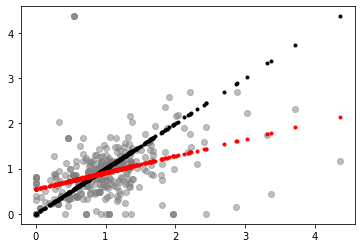

In [29]:

rrs_orig_layer,rfs_orig_layer = ut.loadmat(vip_halo_l4_matfile,['rrs','rfs'])
scall_halo_l4 = opto_utils.norm_to_mean_light_off(rrs_orig_layer[0,0])

xdata = scall_halo_l4[:,:,:,0]
ydata = scall_halo_l4[:,:,:,1]

xdata_trial_av = np.nanmean(scall_halo_l4[:,:,:,0],0)/np.nanmean(scall_halo_l4[:,:,:,0])
ydata_trial_av = np.nanmean(scall_halo_l4[:,:,:,1],0)/np.nanmean(scall_halo_l4[:,:,:,1])

lkat_trial_av = ~np.isnan(xdata_trial_av) & ~np.isnan(ydata_trial_av)
opto_slope_trial_av,opto_intercept_trial_av,_,_,_ = sst.linregress(xdata_trial_av[lkat_trial_av],ydata_trial_av[lkat_trial_av])


xdata = xdata.flatten()
ydata = ydata.flatten()
lkat = ~np.isnan(xdata) & ~np.isnan(ydata)
opto_slope,opto_intercept,_,_,_ = sst.linregress(xdata[lkat],ydata[lkat])


plt.plot(xdata,ydata,'o',color='gray',alpha=0.5)
plt.plot(xdata,xdata,'.k')
plt.plot(xdata,opto_intercept+xdata*opto_slope,'.r')



In [30]:
print("opto_slope_trial_av = "+str(opto_slope_trial_av))
print("opto_intercept_trial_av = "+str(opto_intercept_trial_av))
print("opto_slope = "+str(opto_slope))
print("opto_intercept = "+str(opto_intercept))

opto_slope_trial_av = 0.5968132708883789
opto_intercept_trial_av = 0.40671597127258086
opto_slope = 0.36635697900823594
opto_intercept = 0.5484115392057457


In [6]:
opto_slope

0.36635697900823594

Text(0, 0.5, 'activity change with halo')

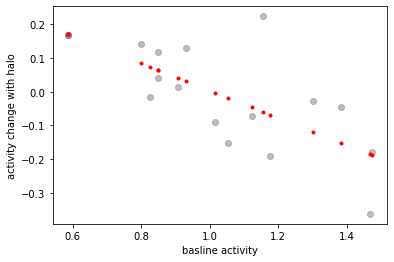

In [32]:
plt.plot(xdata_trial_av,ydata_trial_av-xdata_trial_av,'o',color='gray',alpha=0.5)
plt.plot(xdata_trial_av,opto_intercept_trial_av+xdata_trial_av*opto_slope_trial_av-xdata_trial_av,'.r')
plt.xlabel('basline activity')
plt.ylabel('activity change with halo')

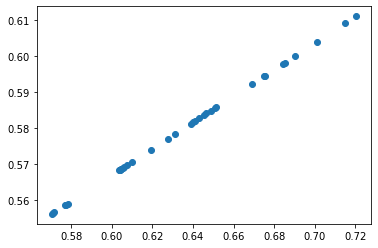

In [33]:
weights_fold = calnet_base + 'weights/weights_%s/'%fit_lbl
weights_files = glob.glob(weights_fold+'*.npy')
weights_files.sort()

mdls = build_models(weights_files)
mdl=mdls[0]
XX_opto = mdl.XX[:,0]*opto_slope + opto_intercept*mdl.XX[:,0].mean(0,keepdims=True)
plt.plot(mdl.XX[:,0],XX_opto,'o')

In [14]:
def compute_opto_line(scall_halo_l4):
    xdata = scall_halo_l4[:,:,:,0]
    ydata = scall_halo_l4[:,:,:,1]
    xdata = xdata.flatten()
    ydata = ydata.flatten()
    lkat = ~np.isnan(xdata) & ~np.isnan(ydata)
    opto_slope,opto_intercept,_,_,_ = sst.linregress(xdata[lkat],ydata[lkat])
    return opto_slope, opto_intercept

def adjust_XX(mdl):
    mdl.XX[:,0::2] = mdl.XX[:,0::2]*opto_slope + opto_intercept*mdl.XX[:,0::2].mean(0,keepdims=True)
    return mdl

def build_models(weights_files):
    #weights_files = np.load(weights_files_list_file,allow_pickle=True)
    nwt = len(weights_files)
    mdls = [None for iwt in range(nwt)]
    for iwt in range(nwt):
        wtdict = np.load(weights_files[iwt],allow_pickle=True)[()]
        mdls[iwt] = cc.ModelOri(wtdict,nT=1)
        # mdls[iwt] = adjust_XX(mdls[iwt])
    return mdls

def run_on_mdl(mdl,sim_options):
    Niter,opto_levels,dt = [sim_options[key] for key in ['Niter','opto_levels','dt']]
    average_last = int(np.floor(Niter/5))
    fix_dim = [2,6]
    this_YY_opto = dyn.compute_steady_state_Model(mdl,Niter=Niter,fix_dim=fix_dim,inj_mag=opto_levels,sim_type='inj',dt=dt)
    to_return = np.nanmean(this_YY_opto[:,:,-average_last:],2)
    return to_return

def simulate_opto_effects(mdls,sim_options=sim_options,pool_size=1):
    nwt = len(mdls)
    Niter,opto_levels,dt = [sim_options[key] for key in ['Niter','opto_levels','dt']]
    nopto = sim_options['opto_levels'].size
    if pool_size==1:
        YY_opto_tavg = np.zeros((nwt,nopto)+mdls[0].Eta.shape)
        for iwt in range(nwt):
            print('model #%d'%iwt)
            YY_opto_tavg[iwt] = run_on_mdl(mdls[iwt],sim_options)
    else:
        with mp.Pool(pool_size) as p:
            YY_opto_tavg = p.starmap(run_on_mdl,[(m,sim_options) for m in mdls])
        YY_opto_tavg = np.array(YY_opto_tavg)

    return YY_opto_tavg

def build_models_and_simulate_opto_effects(weights_files,target_file,sim_options=sim_options,pool_size=1):
    mdls = build_models(weights_files)
    nwt = len(mdls)
    YY_opto_tavg = simulate_opto_effects(mdls,sim_options=sim_options,pool_size=pool_size)
    iwt = 0
    nQ,nS,nT = mdls[iwt].nQ,mdls[iwt].nS,mdls[iwt].nT
    bltiles = np.zeros((nwt,nQ*nS*nT))
    amps = np.ones((nwt,nQ*nS*nT))
    for iwt in range(nwt):
        wtdict = np.load(weights_files[iwt],allow_pickle=True)[()]
        if 'bl' in wtdict:
            bl = wtdict['bl']
            bltiles[iwt] = np.tile(bl,nS*nT)
        if 'amp' in wtdict:
            amp = wtdict['amp']
            amps[iwt] = amp
    YY_opto_tavg = amps[:,np.newaxis,np.newaxis,:]*YY_opto_tavg + bltiles[:,np.newaxis,np.newaxis,:]
    XX_opto = np.concatenate([mdl.XX[np.newaxis] for mdl in mdls],axis=0)
    np.save(target_file,{'YY_opto':YY_opto_tavg,'XX_opto':XX_opto})

def run(fit_lbl,calnet_base=calnet_base,sim_options=sim_options,pool_size=1):
    weights_fold = calnet_base + 'weights/weights_%s/'%fit_lbl
    weights_files = glob.glob(weights_fold+'*.npy')
    weights_files.sort()
    target_file = calnet_base + 'dynamics/vip_halo_opto_tavg_%s.npy'%fit_lbl
    build_models_and_simulate_opto_effects(weights_files,target_file,sim_options=sim_options,pool_size=pool_size)


In [15]:
rrs_orig_layer,rfs_orig_layer = ut.loadmat(vip_halo_l4_matfile,['rrs','rfs'])
scall_halo_l4 = opto_utils.norm_to_mean_light_off(rrs_orig_layer[0,0])
opto_slope,opto_intercept = compute_opto_line(scall_halo_l4)



In [16]:
fit_lbl = '210513c_baby'# sys.argv[1]
print(fit_lbl)
if len(sys.argv)==3:
    pool_size = int(sys.argv[2])
    run(fit_lbl,pool_size=pool_size)
elif len(sys.argv)>3:
    pool_size = int(sys.argv[2])
    calnet_base = sys.argv[3]
    run(fit_lbl,pool_size=pool_size,calnet_base=calnet_base)
else:
    run(fit_lbl)



210513c_baby
model #0
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 

KeyboardInterrupt: 

### Load Output

In [34]:
fit_lbl='210513c_baby'
npyfile = np.load(f'{calnet_base}/dynamics/vip_halo_opto_tavg_%s.npy'%fit_lbl,allow_pickle=True)[()]
YY_opto = npyfile['YY_opto'][:,:,:,np.newaxis,:]
YY_opto.shape
opto_levels = 1*np.linspace(-1,1,YY_opto.shape[1])
ucontrast=np.array([0,6,12,25,50,100])

network_resp=np.nanmean(YY_opto,3)



FileNotFoundError: [Errno 2] No such file or directory: '/Users/agos/Dropbox/ColumbiaProjects/Project_DansPaper/calnet_data//dynamics/vip_halo_opto_tavg_210513c_baby.npy'